In [1]:
from helpers import *

In [2]:
def get_data(path, test_start, test_end, target='F380 M2/M3'):
    data = pd.read_csv(path)
    data.pricing_date = pd.to_datetime(data.pricing_date)
    data.set_index('pricing_date', inplace=True)
    data.interpolate('linear', inplace=True)
    return data


def lookback(data, col, t_val):
    sequence = list(range(1, t_val))
    
    data_reversed = data[::-1]  # Reverse the dataset
    shifted = pd.DataFrame(columns=[f'{col}', * [f'{col}_t-{x}' for x in sequence]], index=data_reversed.index)
    
    for i, (idx, row) in enumerate(data_reversed.iterrows()):
        vals = [row[col]]
        for ix in sequence:
            try:
                if i + ix < len(data_reversed):
                    val = data_reversed.iloc[i + ix][col]
                    vals.append(val)
                else:
                    vals.append(np.nan)
            except IndexError:
                vals.append(np.nan)
            except ZeroDivisionError:
                vals.append(np.nan)
        
        shifted.iloc[i, :] = vals
        
    shifted = shifted[::-1]
    return shifted


def get_columns(cols):
    columns = []
    
    for c in cols:
        if 'rgp' in c or c in ['P66SG', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'ENOC', 'GUNVORSG',
                               'VITOLSG', 'BPSG', 'PETROCHINA']:
            columns.append(c)
    
    return columns


def lookahead(data, col, t_val):
    sequence = list(range(1, t_val + 1))
    shifted = pd.DataFrame(columns=[f'{col}+{x}' for x in sequence], index=data.index)
    
    for i, (idx, row) in enumerate(data[[col]].iterrows()):
        vals = []
        
        for ix in sequence:
            try:
                ixs = i + ix
                
                if ixs > len(data):
                    vals.append(np.nan)
                    # break
                else:
                    val = data.iloc[ixs][col]
                    vals.append(val)
            except IndexError:
                vals.append(np.nan)
            except ZeroDivisionError:
                vals.append(np.nan)
        
        shifted.iloc[i, :] = vals
    
    return shifted


def add_all_cols(data, columns, func, t_val):
    new_df = pd.DataFrame(index=data.index)

    for col in columns:
        new_df = pd.concat([new_df, func(data, col, t_val)], axis=1)

    return new_df

In [3]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# import talib
# from scipy.stats import zscore

# class TargetFeature:
#     def __init__(self, results_path, data, test_start, test_end, target='F380 M2/M3',
#                  features=None, **kwargs):
#         self.results_path = results_path

#         self.data = data
#         self.test_start = test_start
#         self.test_end = test_end
#         self.target = target
#         self.features = features

#         # define pd.DataFrame to store resulting df
#         self.target_and_feature = None

#         # define scaler
#         self.scaler = MinMaxScaler()

#         # define a starting message for log
#         self.message = 'Task 2 [TargetFeature]:\n\t'

#     def __call__(self, *args, **kwargs):
#         self._setup()

#     def _setup(self):
#         # self.log(self.log_path, f'{self.message}Internal setup for target and feature columns...')
#         target = self.data[self.target]
#         target.interpolate(inplace=True)
#         target.dropna(inplace=True)
        
#         self.target_and_feature = pd.DataFrame(index=self.data.index)
#         self.target_and_feature['actual_target'] = target
#         self.target_and_feature['predicted_target'] = target
        
        
#         # self.mu = self.target[:self.test_start].mean()
        
        
#         if self.features is not None:            
#             decompose = seasonal_decompose(target, model='additive', period=4)
            
#             for feature in self.features:
#                 if feature in ['rsi', 'all']:
#                     rsi = pd.DataFrame(talib.RSI(target), columns=['rsi'])
#                     self.target_and_feature['actual_rsi'] = rsi[:self.test_end]
#                     self.target_and_feature['predicted_rsi'] = rsi[:self.test_start]
#                 if feature in ['rolling', 'all']:
#                     rolling = self.data[self.target].rolling(30).mean()
#                     self.target_and_feature['actual_rolling'] = rolling[:self.test_end]
#                     self.target_and_feature['predicted_rolling'] = rolling[:self.test_start]
#                 if feature in ['zscore', 'all']:
#                     zscores = (target[:self.test_start] - self.target_and_feature['predicted_rolling']) / target[:self.test_start].rolling(window=30).std()
#                     self.target_and_feature['actual_zscore'] = zscores[:self.test_end]
#                     self.target_and_feature['predicted_zscore'] = zscores[:self.test_start]
#                 if feature in ['seasonality', 'all']:
#                     self.target_and_feature['actual_seasonality'] = decompose.seasonal
#                 if feature in ['fft', 'all']:
#                     fft_value = np.fft.fft(target)
#                     self.target_and_feature['actual_fft_real'] = fft_value.real
#                     self.target_and_feature['predicted_fft_real'] = self.target_and_feature['actual_fft_real'][:self.test_start]
#                     self.target_and_feature['actual_fft_imag'] = fft_value.imag
#                     self.target_and_feature['predicted_fft_imag'] = self.target_and_feature['actual_fft_imag'][:self.test_start]
#                 if feature in ['diff', 'all']:
#                     self.target_and_feature['actual_diff'] = target.diff()
#                     self.target_and_feature['predicted_diff'] = self.target_and_feature['actual_diff'][:self.test_start]
#                 if feature in ['seasonal_diff', 'all']:
#                     self.target_and_feature['actual_seasonal_diff'] = decompose.seasonal.diff()
#                 if feature in ['ewm', 'all']:
#                     self.target_and_feature['actual_ewm'] = target.ewm(span=30, adjust=True).mean()
#                     self.target_and_feature['predicted_ewm'] = self.target_and_feature['actual_ewm'][:self.test_start]
            
#             # self.target_and_feature.dropna(inplace=True)

#             # fit a scaler
#             columns = [x for x in self.target_and_feature if 'predicted' not in x and 'target' not in x]
#             print('TargetFeature columns:', columns)
#             self.scaler.fit(self.target_and_feature[columns])


#     def get_target_feature(self, end_date, start_date=None, include_past=False):
#         # return all values until specified date
#         if include_past:
#             if start_date is not None:
#                 # self.log(self.log_path, f'Returning dates from {start_date} to {end_date}.')
#                 return self.target_and_feature.loc[start_date:end_date, :]
#             # self.log(self.log_path, f'Returning all dates until {end_date}')
#             return self.target_and_feature.loc[:end_date, :]

#         # return one-day results
#         try:
#             entry = pd.DataFrame(self.target_and_feature.loc[end_date, :]).T
#         except KeyError:
#             # self.log(self.log_path, f'{self.message}Date {end_date} does not exist!', CRITICAL)
#             raise KeyError(f'{self.message}Date {end_date} does not exist!')
#         else:
#             # self.log(self.log_path, f'Returned one-day instance for {end_date}.')
#             return entry

#     def set_target_feature(self, date, column, value):
#         fmt = '%Y-%m-%d'

#         # raise error if the supplemented date is less than the test start
#         # if datetime.strptime(self.test_start, fmt) < datetime.strptime(date, fmt):
#         #     message = f'Illegal date substitution {date}, expected to see dates between {self.test_start} to {date}.'
#         #     self.log(self.log_path, self.message + message, CRITICAL)
#         #     raise Exception(message)
        
#         # with open('track.txt', 'a') as fout:
#         #     fout.writelines(f'{date} - {column}: {value}\n')

#         # get previous value
#         previous = self.target_and_feature.loc[date, column]

#         # log information
#         # self.log(self.log_path, f'{self.message}Setting new value for {column}. Old: {previous}, new: {value}')

#         # set new value
#         self.target_and_feature.loc[date, column] = value

#         # save current state
#         # self.target_and_feature.reset_index(inplace=True)
#         self.target_and_feature.to_csv(f'{self.results_path}/complete_target_feature_df.csv', index=True)
#         # self.log(self.log_path, f'{self.message}Saving intermediate results in {self.results_path} CSV file.')


In [4]:
def get_t_columns(df, current_date, t_value, columns=None):
    if columns is None:
        columns = get_columns(df.columns.tolist())
    
    for c in columns:
        df = pd.concat([df, lookahead(df[df.index >= current_date], c, t_value)], axis=1)
    
    return df
    

In [5]:


def train_model(data, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, final_refit=True, path=None, 
                use_features=False, n_estimators=1500, target_features=None, feat_importance='total_gain'):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    
    data.interpolate('linear', inplace=True)
    data.dropna(inplace=True)
    
    # create a target feature class
    if target_features is None:
        target_feature = TargetFeature(path, data, test_start, test_end, features=None)
    else:
        target_features = [target_features] if isinstance(target_features, str) else target_features
        print('Target features:', target_features)
        target_feature = TargetFeature(path, data, test_start, test_end, features=target_features)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    if target_col in columns:
        columns = list(columns)
        columns.remove(target_col)
        
    if len(columns) > 1:
        data = data[columns]
    
    # split to train/test
    train = data[data.index < test_start]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    # target_scaler = MinMaxScaler()
    target_scaler = target_feature.scaler
    
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    if use_features:
    
        all_target_cols = ['actual_rolling', 'actual_seasonality', 'actual_fft_real', 'actual_fft_imag', 'actual_diff', 'actual_seasonal_diff', 'actual_ewm', 'actual_zscore', 'actual_rsi']
        all_pred_target_cols = ['predicted_rolling', 'predicted_fft_real', 'predicted_fft_imag', 'predicted_diff', 'predicted_ewm', 'predicted_zscore', 'predicted_rsi']

        current_target_cols = [col for col in all_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_target_cols
        print('Current target columns:', current_target_cols)
        current_pred_target_cols = [col for col in all_pred_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_pred_target_cols
        
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns) + len(current_target_cols)}_use_fe={use_features}_feat-import={feat_importance}_targ_fe={"_".join(target_features)}.model'
    else:
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns)}_use_fe={use_features}_feat-import={feat_importance}_targ_fe=False.model'
    
    if not os.path.exists(model_name):
        os.makedirs('/'.join(model_name.split('/')[:-1]))
    
    
    # start pretraining the model
    for idx in range(300):
        # get batches
        train_temp, valid_temp = iterate(train, idx, low=False)

        # break if there are fewer values
        if len(train_temp) < 200 or len(valid_temp) <= 5: break

        # get rolling and target columns
        if use_features:
            targets = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                        include_past=True)[[target] + current_target_cols]
            train_temp[[target_col] + current_target_cols] = targets.shift(10, fill_value=0).values
                
            targets = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                        include_past=True)[[target] + current_target_cols]    
            
            valid_temp[[target_col] + current_target_cols] = targets.shift(10, fill_value=0).values
                

            print(train_temp.columns)
            print(valid_temp.columns)

            train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_temp.dropna(inplace=True)
            valid_temp.dropna(inplace=True)
            
            y_train = train_temp[target_col]
            y_test = valid_temp[target_col]
            
            train_temp.drop(columns=target_col, inplace=True)
            valid_temp.drop(columns=target_col, inplace=True)
            
            # train_temp[current_target_cols] = target_feature.scaler.transform(train_temp[current_target_cols])
            # valid_temp[current_target_cols] = target_feature.scaler.transform(valid_temp[current_target_cols])

            
            train_temp[current_target_cols] = target_scaler.transform(train_temp[current_target_cols])
            valid_temp[current_target_cols] = target_scaler.transform(valid_temp[current_target_cols])

            
        else:
            y_train = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[target].values
            y_test = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[target].values

        if idx == 0:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist')
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)
            
        else:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
            model.load_model(model_name)
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)

        model.save_model(model_name)

    # final refit
    full_train = train.copy()
    
    if use_features:
        targets = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[[target] + current_target_cols]
        full_train[[target_col] + current_target_cols] = targets.shift(10, fill_value=0).values

    else:
        full_train[target_col] = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[target].values
        
    full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_train.dropna(inplace=True)
    
    y_train = full_train[target_col]
    full_train.drop(columns=target_col, inplace=True)

    # if use_features:
    #     # normalize data
    #     full_train[current_target_cols] = full_train[current_target_cols]
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
    model.load_model(model_name)
    model.fit(full_train, y_train, verbose=False)

    model.save_model(model_name)

    if use_features:
        return model, train, test, scaler, target_feature, current_target_cols, model_name, target_scaler
    
    return model, train, test, scaler, target_feature, model_name


def get_columns(columns_selection, model, feat_eng_thresh=30, feat_importance='total_gain'):
    if columns_selection == 'xgboost':
        scores = model.get_booster().get_score(importance_type=feat_importance)
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] >= feat_eng_thresh]['columns'].to_list()


def get_predictions(data, t_value, results_folder, test_start, test_end, columns_selection='xgboost', use_features=False, 
                    n_estimators=100, target_features=None, use_fe=False, feat_eng_thresh=30, feat_importance='total_gain'):
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    
    actual_target_scaler = MinMaxScaler()
    actual_target_scaler.fit(data[data.index < test_start].interpolate('linear')[['F380 M2/M3']])
    
    if use_fe:
        model, train, test, scaler, target_feature, model_name, target_scaler = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                 columns=data.columns, path=results_folder, 
                                                                 use_features=False, n_estimators=n_estimators, target_features=None,
                                                                 feat_importance='total_gain')

        columns = get_columns(columns_selection, model, feat_eng_thresh, feat_importance=feat_importance)
        columns = [x for x in columns if not x.startswith('rolling')]
        
        print('Removing temporary model:', model_name)
        os.remove(model_name)
    else:
        columns = data.drop(columns='F380 M2/M3').columns
    
    # refit the model with selected columns
    if use_features:
        model, train, test, scaler, target_feature, current_target_cols, model_name, target_scaler = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                                                model_suffix='partial', columns=columns, path=results_folder, 
                                                                                                use_features=use_features, n_estimators=n_estimators, 
                                                                                                target_features=target_features, feat_importance=feat_importance)
        print('Current target cols:', current_target_cols)
    else:
        model, train, test, scaler, target_feature, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                            model_suffix='partial', columns=columns, path=results_folder, 
                                                                            use_features=use_features, n_estimators=n_estimators, 
                                                                            target_features=target_features, feat_importance=feat_importance)
    
    print('============')
    print(f'Use target features: {use_features} [{target_features}]')
    print(f'Use feature engineering for column selection: {use_fe} [type={feat_importance} >= {feat_eng_thresh}]')
    print('Model is stored in:', model_name)
    print('Number of columns:', len(columns))
    print('Columns:', columns, end='\n============\n')
    
    # target_scaler = target_feature.scaler
    
    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()

    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy().drop(columns='F380 M2/M3')
            test_date = sliding_history.index.min()
            print('Test date:', test_date)
            
            testx = sliding_history.loc[:test_date, :]
            # testx = pd.DataFrame(scaler.transform(testx.drop(columns='F380 M2/M3')), index=testx.index, columns=testx.drop(columns='F380 M2/M3').columns)
            
            print(testx)
            
            try:
                date_until = full_history[full_history.index > sliding_history.index.min()].index.tolist()[0]
                # date_until = test_date
                print('Date until:', date_until)
            except Exception:
                print('Aborting the pipeline...')
            else:
                tfeatures = target_feature.get_target_feature(date_until, full_history.index.min(), True)['actual_target']
                
                if isinstance(t_value, int) and t_value > 0:
                    tfeatures = tfeatures.shift(t_value, fill_value=0)
                    print(tfeatures.iloc[-1])
                
                if use_features:
                    feats = pd.DataFrame(index=tfeatures.index)
                    
                    for feature in current_target_cols:
                        if feature == 'actual_zscore':
                            method = zscore(tfeatures)
                        if feature == 'actual_rsi':
                            method = talib.RSI(tfeatures)
                        if feature == 'actual_rolling':
                            method = tfeatures.rolling(5).mean()
                        if feature == 'actual_ewm':
                            method = tfeatures.ewm(span=30, adjust=True).mean()
                
                        feats[feature] = method
                    
                    # if isinstance(t_value, int) and t_value > 0:
                    #     feats = feats.shift(t_value, fill_value=0)
                    
                    try:
                        features = feats.copy()
                        # features = pd.DataFrame(target_scaler.transform(feats), index=feats.index, columns=feats.columns)
                        print('Features:', features)
                    except ValueError:
                        pass
                    
                    # break
                    
                    for col in features.columns:
                        testx[col] = features.loc[:, col][test_date]
                
                print('Testx:', testx)
                
                testx = testx.astype(float)
                testx.drop(columns='F380 M2/M3', inplace=True)
                
                # get predictions
                predictions = model.predict(pd.DataFrame(testx.iloc[0]).T)
                print(predictions)
                
                with open('test_dates_no_norm4.txt', 'a') as fout:
                    fout.writelines(f'Test date: {sliding_history.index.tolist()[0]}\nFeatures: {features.iloc[-2]}\n Target df: {tfeatures.iloc[-2]}\nPrediction: {predictions[0]} \t Target: {tfeatures.iloc[-2]}\n Testx: {pd.DataFrame(testx.iloc[0]).T}\n======\n')
                
                print(actual_target_scaler.transform(pd.DataFrame({'F380 M2/M3': [predictions]}, index=pd.DataFrame(testx.iloc[0]).T.index)))
                
                results_df = pd.concat([results_df, pd.DataFrame({
                    'pricing_date': [sliding_history.index[0]],
                    'preds': predictions,
                    # 'preds': actual_target_scaler.transform(pd.DataFrame({'F380 M2/M3': [predictions]}, index=pd.DataFrame(testx.iloc[0]).T.index))[0],
                    'target': [tfeatures.iloc[-1]],
                    'forecast_date': sliding_history.index.min()
                })])
                    
    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    
    # Assuming df is your DataFrame containing the data
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on the "target" column
    scaler.fit(np.array(results_df['target']).reshape(-1, 1))

    # Transform the "preds" column using the scaler
    results_df['preds_rescaled'] = scaler.inverse_transform(np.array(results_df['preds'].values).reshape(-1, 1))

    show_plot(results_df, 'preds_rescaled')

    return {'results_df': results_df, 'model': model, 'target_feature': target_feature, 
            'target_features': target_features, 'model_name': model_name, 'columns': columns,
            'scaler': scaler}

In [6]:
data = get_data('../data/data_2024-02-02.csv', '2023-01-01', '2024-01-01')

data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)

data['year_num'] = data.index.year
data['month_num'] = data.index.month
data['day_num'] = data.index.day
data['dow_num'] = data.index.dayofweek

data

,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,CAOSG,...,_rgp_11_sz_3,F380 M2/M3,year_sin,month_sin,day_sin,dow_sin,year_num,month_num,day_num,dow_num
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.50,-2.172867e-02,0.500000,0.897805,1.000000e+00,2017,1,10,1
2017-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.30,-2.172867e-02,0.500000,0.790776,1.224647e-16,2017,1,11,2
2017-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.70,-2.172867e-02,0.500000,0.651372,-1.000000e+00,2017,1,12,3
2017-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.85,-2.172867e-02,0.500000,0.485302,-2.449294e-16,2017,1,13,4
2017-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.00,-2.172867e-02,0.500000,-0.101168,0.000000e+00,2017,1,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.30,-2.449294e-16,0.866025,-0.848644,0.000000e+00,2024,2,26,0
2024-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.30,-2.449294e-16,0.866025,-0.724793,1.000000e+00,2024,2,27,1
2024-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.30,-2.449294e-16,0.866025,-0.571268,1.224647e-16,2024,2,28,2


In [7]:
target = data['F380 M2/M3']
data.drop(columns='F380 M2/M3', inplace=True)
data = add_all_cols(data, data.columns.tolist(), lookahead, 10)
data

,ALVARI+1,ALVARI+2,ALVARI+3,ALVARI+4,ALVARI+5,ALVARI+6,ALVARI+7,ALVARI+8,ALVARI+9,ALVARI+10,...,dow_num+1,dow_num+2,dow_num+3,dow_num+4,dow_num+5,dow_num+6,dow_num+7,dow_num+8,dow_num+9,dow_num+10
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0
2017-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0
2017-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0
2017-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0
2017-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-27,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-28,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Target features: ['zscore', 'rsi']
TargetFeature columns: ['actual_zscore', 'actual_rsi']
Current target columns: ['actual_zscore', 'actual_rsi']
Index(['ALVARI+1', 'ALVARI+2', 'ALVARI+3', 'ALVARI+4', 'ALVARI+5', 'ALVARI+6',
       'ALVARI+7', 'ALVARI+8', 'ALVARI+9', 'ALVARI+10',
       ...
       'dow_num+4', 'dow_num+5', 'dow_num+6', 'dow_num+7', 'dow_num+8',
       'dow_num+9', 'dow_num+10', 'F380 M2/M3', 'actual_zscore', 'actual_rsi'],
      dtype='object', length=743)
Index(['ALVARI+1', 'ALVARI+2', 'ALVARI+3', 'ALVARI+4', 'ALVARI+5', 'ALVARI+6',
       'ALVARI+7', 'ALVARI+8', 'ALVARI+9', 'ALVARI+10',
       ...
       'dow_num+4', 'dow_num+5', 'dow_num+6', 'dow_num+7', 'dow_num+8',
       'dow_num+9', 'dow_num+10', 'F380 M2/M3', 'actual_zscore', 'actual_rsi'],
      dtype='object', length=743)
Index(['ALVARI+1', 'ALVARI+2', 'ALVARI+3', 'ALVARI+4', 'ALVARI+5', 'ALVARI+6',
       'ALVARI+7', 'ALVARI+8', 'ALVARI+9', 'ALVARI+10',
       ...
       'dow_num+4', 'dow_num+5', 'dow_num+6'

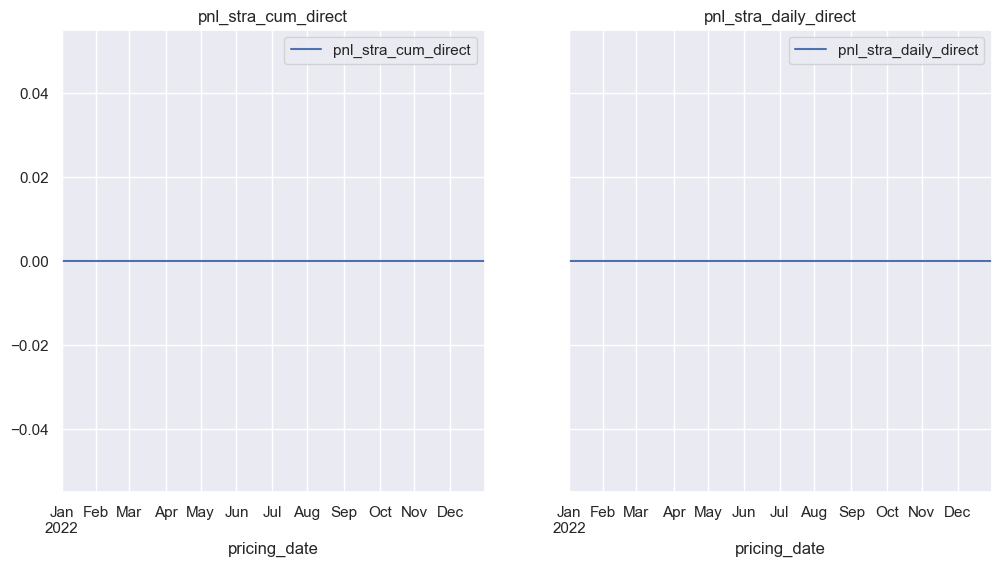

In [8]:
data2 = data.copy()
data2['F380 M2/M3'] = target.values

results = get_predictions(data2, t_value=10, results_folder='experiments/test', test_start='2022-01-01', 
                test_end='2023-01-01', columns_selection='xgboost', use_features=True, 
                n_estimators=100, target_features=['zscore', 'rsi'])
    

In [11]:
show_plot(results['results_df'], 'preds')

In [8]:


def train_model(data, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, final_refit=True, path=None, 
                use_features=False, n_estimators=1500, target_features=None, feat_importance='total_gain'):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    
    data.interpolate('linear', inplace=True)
    data.dropna(inplace=True)
    
    # create a target feature class
    if target_features is None:
        target_feature = TargetFeature(path, data, test_start, test_end, features=None)
    else:
        target_features = [target_features] if isinstance(target_features, str) else target_features
        print('Target features:', target_features)
        target_feature = TargetFeature(path, data, test_start, test_end, features=target_features)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    if target_col in columns:
        columns = list(columns)
        columns.remove(target_col)
        
    if len(columns) > 1:
        data = data[columns]
    
    # split to train/test
    train = data[data.index < test_start]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    # target_scaler = MinMaxScaler()
    target_scaler = target_feature.scaler
    
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    if use_features:
    
        all_target_cols = ['actual_zscore', 'actual_rsi', 'actual_rolling', 'actual_seasonality', 'actual_fft_real', 'actual_fft_imag', 'actual_diff', 'actual_seasonal_diff', 'actual_ewm']
        all_pred_target_cols = ['predicted_zscore', 'predicted_rsi', 'predicted_rolling', 'predicted_fft_real', 'predicted_fft_imag', 'predicted_diff', 'predicted_ewm']

        current_target_cols = [col for col in all_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_target_cols
        print('Current target columns:', current_target_cols)
        current_pred_target_cols = [col for col in all_pred_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_pred_target_cols
        
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns) + len(current_target_cols)}_use_fe={use_features}_feat-import={feat_importance}_targ_fe={"_".join(target_features)}.model'
    else:
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns)}_use_fe={use_features}_feat-import={feat_importance}_targ_fe=False.model'

    try:    
        if not os.path.exists(model_name):
            os.makedirs('/'.join(model_name.split('/')[:-1]))
    except Exception:
        print('skipping')
    
    
    # start pretraining the model
    for idx in range(300):
        # get batches
        train_temp, valid_temp = iterate(train, idx, low=False)

        # break if there are fewer values
        if len(train_temp) < 200 or len(valid_temp) <= 5: break

        # get rolling and target columns
        if use_features:
            targets = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                        include_past=True)[[target] + current_target_cols]
            train_temp[[target_col] + current_target_cols] = targets.shift(10, fill_value=0).values
                
            targets = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                        include_past=True)[[target] + current_target_cols]    
            
            valid_temp[[target_col] + current_target_cols] = targets.shift(10, fill_value=0).values
                

            print(train_temp.columns)
            print(valid_temp.columns)

            train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_temp.dropna(inplace=True)
            valid_temp.dropna(inplace=True)
            
            y_train = train_temp[target_col]
            y_test = valid_temp[target_col]
            
            train_temp.drop(columns=target_col, inplace=True)
            valid_temp.drop(columns=target_col, inplace=True)
            
            # train_temp[current_target_cols] = target_feature.scaler.transform(train_temp[current_target_cols])
            # valid_temp[current_target_cols] = target_feature.scaler.transform(valid_temp[current_target_cols])

            
            train_temp[current_target_cols] = target_scaler.transform(train_temp[current_target_cols])
            valid_temp[current_target_cols] = target_scaler.transform(valid_temp[current_target_cols])

            
        else:
            y_train = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[target].values
            y_test = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[target].values

        if idx == 0:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist')
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)
            
        else:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
            model.load_model(model_name)
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)

        model.save_model(model_name)

    # final refit
    full_train = train.copy()
    
    if use_features:
        targets = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[[target] + current_target_cols]
        full_train[[target_col] + current_target_cols] = targets.shift(10, fill_value=0).values

    else:
        full_train[target_col] = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[target].values
        
    full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_train.dropna(inplace=True)
    
    y_train = full_train[target_col]
    full_train.drop(columns=target_col, inplace=True)

    # if use_features:
    #     # normalize data
    #     full_train[current_target_cols] = full_train[current_target_cols]
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
    model.load_model(model_name)
    model.fit(full_train, y_train, verbose=False)

    model.save_model(model_name)

    if use_features:
        return model, train, test, scaler, target_feature, current_target_cols, model_name, target_scaler
    
    return model, train, test, scaler, target_feature, model_name


def get_columns(columns_selection, model, feat_eng_thresh=30, feat_importance='total_gain'):
    if columns_selection == 'xgboost':
        scores = model.get_booster().get_score(importance_type=feat_importance)
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] >= feat_eng_thresh]['columns'].to_list()


def get_predictions(data, t_value, results_folder, test_start, test_end, columns_selection='xgboost', use_features=False, 
                    n_estimators=100, target_features=None, use_fe=False, feat_eng_thresh=30, feat_importance='total_gain'):
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    
    actual_target_scaler = MinMaxScaler()
    actual_target_scaler.fit(data[data.index < test_start].interpolate('linear')[['F380 M2/M3']])
    
    if use_fe:
        model, train, test, scaler, target_feature, model_name, target_scaler = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                 columns=data.columns, path=results_folder, 
                                                                 use_features=False, n_estimators=n_estimators, target_features=None,
                                                                 feat_importance='total_gain')

        columns = get_columns(columns_selection, model, feat_eng_thresh, feat_importance=feat_importance)
        columns = [x for x in columns if not x.startswith('rolling')]
        
        print('Removing temporary model:', model_name)
        os.remove(model_name)
    else:
        columns = data.drop(columns='F380 M2/M3').columns
    
    # refit the model with selected columns
    if use_features:
        model, train, test, scaler, target_feature, current_target_cols, model_name, target_scaler = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                                                model_suffix='partial', columns=columns, path=results_folder, 
                                                                                                use_features=use_features, n_estimators=n_estimators, 
                                                                                                target_features=target_features, feat_importance=feat_importance)
        print('Current target cols:', current_target_cols)
    else:
        model, train, test, scaler, target_feature, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                            model_suffix='partial', columns=columns, path=results_folder, 
                                                                            use_features=use_features, n_estimators=n_estimators, 
                                                                            target_features=target_features, feat_importance=feat_importance)
    
    print('============')
    print(f'Use target features: {use_features} [{target_features}]')
    print(f'Use feature engineering for column selection: {use_fe} [type={feat_importance} >= {feat_eng_thresh}]')
    print('Model is stored in:', model_name)
    print('Number of columns:', len(columns))
    print('Columns:', columns, end='\n============\n')
    
    # target_scaler = target_feature.scaler
    
    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()

    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy().drop(columns='F380 M2/M3')
            test_date = sliding_history.index.min()
            print('Test date:', test_date)
            
            testx = sliding_history.loc[:test_date, :]
            # testx = pd.DataFrame(scaler.transform(testx.drop(columns='F380 M2/M3')), index=testx.index, columns=testx.drop(columns='F380 M2/M3').columns)
            
            print(testx)
            
            try:
                date_until = full_history[full_history.index > sliding_history.index.min()].index.tolist()[0]
                # date_until = test_date
                print('Date until:', date_until)
            except Exception:
                print('Aborting the pipeline...')
            else:
                tfeatures = target_feature.get_target_feature(date_until, full_history.index.min(), True)['actual_target']
                
                if isinstance(t_value, int) and t_value > 0:
                    tfeatures = tfeatures.shift(t_value, fill_value=0)
                    print(tfeatures.iloc[-1])
                
                if use_features:
                    feats = pd.DataFrame(index=tfeatures.index)
                    
                    for feature in current_target_cols:
                        if feature == 'actual_zscore':
                            method = zscore(tfeatures)
                        if feature == 'actual_rsi':
                            method = talib.RSI(tfeatures)
                        if feature == 'actual_rolling':
                            method = tfeatures.rolling(5).mean()
                        if feature == 'actual_ewm':
                            method = tfeatures.ewm(span=30, adjust=True).mean()
                
                        feats[feature] = method
                    
                    # if isinstance(t_value, int) and t_value > 0:
                    #     feats = feats.shift(t_value, fill_value=0)
                    
                    try:
                        features = feats.copy()
                        # features = pd.DataFrame(target_scaler.transform(feats), index=feats.index, columns=feats.columns)
                        print('Features:', features)
                    except ValueError:
                        pass
                    
                    # break
                    
                    for col in features.columns:
                        testx[col] = features.loc[:, col][test_date]
                
                print('Testx:', testx)
                
                testx = testx.astype(float)
                testx.drop(columns='F380 M2/M3', inplace=True)
                
                # get predictions
                predictions = model.predict(pd.DataFrame(testx.iloc[0]).T)
                print(predictions)
                
                with open('test_dates_no_norm4.txt', 'a') as fout:
                    fout.writelines(f'Test date: {sliding_history.index.tolist()[0]}\nFeatures: {features.iloc[-2]}\n Target df: {tfeatures.iloc[-2]}\nPrediction: {predictions[0]} \t Target: {tfeatures.iloc[-2]}\n Testx: {pd.DataFrame(testx.iloc[0]).T}\n======\n')
                
                print(actual_target_scaler.transform(pd.DataFrame({'F380 M2/M3': [predictions]}, index=pd.DataFrame(testx.iloc[0]).T.index)))
                
                results_df = pd.concat([results_df, pd.DataFrame({
                    'pricing_date': [sliding_history.index[0]],
                    'preds': predictions,
                    # 'preds': actual_target_scaler.transform(pd.DataFrame({'F380 M2/M3': [predictions]}, index=pd.DataFrame(testx.iloc[0]).T.index))[0],
                    'target': [tfeatures.iloc[-1]],
                    'forecast_date': sliding_history.index.min()
                })])
                    
    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    
    # Assuming df is your DataFrame containing the data
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on the "target" column
    scaler.fit(np.array(results_df['target']).reshape(-1, 1))

    # Transform the "preds" column using the scaler
    results_df['preds_rescaled'] = scaler.inverse_transform(np.array(results_df['preds'].values).reshape(-1, 1))

    show_plot(results_df, 'preds_rescaled')

    return {'results_df': results_df, 'model': model, 'target_feature': target_feature, 
            'target_features': target_features, 'model_name': model_name, 'columns': columns,
            'scaler': scaler}

Target features: ['zscore', 'rsi', 'rolling']
TargetFeature columns: ['actual_zscore', 'actual_rsi', 'actual_rolling']
Current target columns: ['actual_zscore', 'actual_rsi', 'actual_rolling']
Index(['ALVARI+1', 'ALVARI+2', 'ALVARI+3', 'ALVARI+4', 'ALVARI+5', 'ALVARI+6',
       'ALVARI+7', 'ALVARI+8', 'ALVARI+9', 'ALVARI+10',
       ...
       'dow_num+5', 'dow_num+6', 'dow_num+7', 'dow_num+8', 'dow_num+9',
       'dow_num+10', 'F380 M2/M3', 'actual_zscore', 'actual_rsi',
       'actual_rolling'],
      dtype='object', length=744)
Index(['ALVARI+1', 'ALVARI+2', 'ALVARI+3', 'ALVARI+4', 'ALVARI+5', 'ALVARI+6',
       'ALVARI+7', 'ALVARI+8', 'ALVARI+9', 'ALVARI+10',
       ...
       'dow_num+5', 'dow_num+6', 'dow_num+7', 'dow_num+8', 'dow_num+9',
       'dow_num+10', 'F380 M2/M3', 'actual_zscore', 'actual_rsi',
       'actual_rolling'],
      dtype='object', length=744)
Index(['ALVARI+1', 'ALVARI+2', 'ALVARI+3', 'ALVARI+4', 'ALVARI+5', 'ALVARI+6',
       'ALVARI+7', 'ALVARI+8', 'ALVARI+9

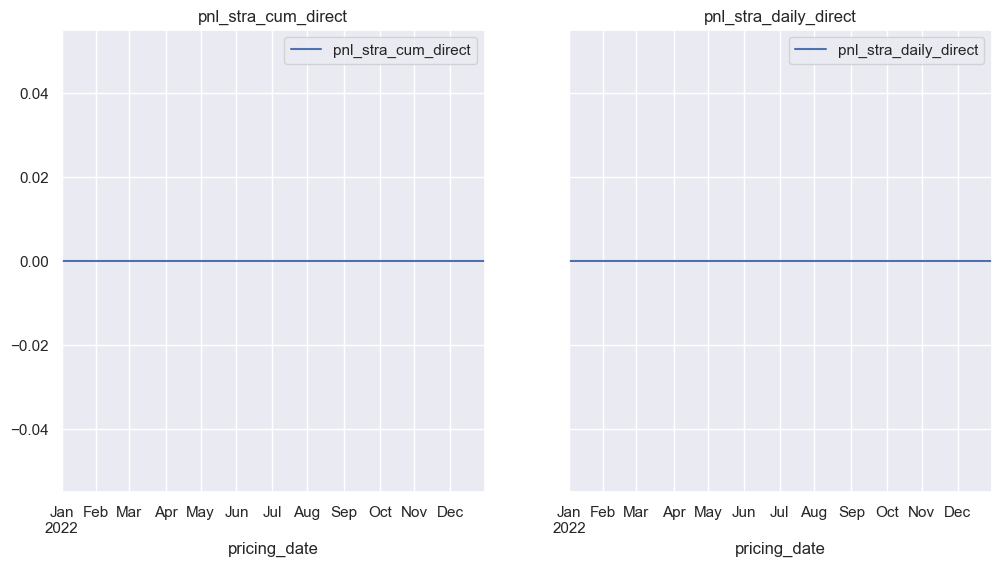

In [9]:
data2 = data.copy()
data2['F380 M2/M3'] = target.values

results = get_predictions(data2, t_value=10, results_folder='experiments/test', test_start='2022-01-01', 
                test_end='2023-01-01', columns_selection='xgboost', use_features=True, 
                n_estimators=100, target_features=['zscore', 'rsi', 'rolling'])
    

In [10]:
def show_plot(df, pred='preds'):
    agg_data = df.copy()
    agg_data['pricing_date'] = pd.to_datetime(agg_data['pricing_date'])
    agg_data['forecast_date'] = agg_data['forecast_date'].astype(str)

    agg_data = agg_data.set_index('pricing_date')

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    fig = go.Figure()  # Define the figure first
    colors = df['forecast_date'].tolist()

    fig.add_trace(go.Scatter(x=df.index, y=df[pred], name='pred', mode='lines+markers', opacity=0.5,
                            line=dict(width=2, color='red')))

    x = df.index
    y = df['target']
    name = 'target'
    fig.add_trace(go.Scatter(x=x, y=y, name=name, mode='lines+markers', opacity=0.5, marker=dict(color='darkgray', size=10),
                             line=dict(width=2, color='gray')))

    fig.show()
    
    
 # Assuming df is your DataFrame containing the data
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the "target" column
scaler.fit(np.array(results['results_df']['target']).reshape(-1, 1))

# Transform the "preds" column using the scaler
results['results_df']['preds_rescaled'] = scaler.inverse_transform(np.array(results['results_df']['preds'].values).reshape(-1, 1))

show_plot(results['results_df'], 'preds_rescaled')   

# show_plot()

In [11]:
results_df = results['results_df']
results_df

,pricing_date,preds,target,forecast_date,nth_day,preds_diff,traget_diff,preds_diff_cum,traget_diff_cum,preds_direct,traget_direct,preds_direct_cum,traget_direct_cum,pnl_stra_daily_direct,pnl_stra_cum_direct,preds_rescaled
0,2022-01-03,-0.512325,-0.750,2022-01-03,0,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-14.862247
0,2022-01-04,-0.665785,-0.500,2022-01-04,0,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-17.816366
0,2022-01-05,-0.515632,-0.250,2022-01-05,0,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-14.925920
0,2022-01-06,-0.513829,-0.250,2022-01-06,0,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-14.891208
0,2022-01-07,-0.513012,-0.175,2022-01-07,0,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-14.875486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2022-12-26,-0.914870,-2.500,2022-12-26,0,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-22.611238
0,2022-12-27,-0.916320,-1.450,2022-12-27,0,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-22.639154
0,2022-12-28,-0.656407,-1.750,2022-12-28,0,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-17.635824
0,2022-12-29,-0.740284,-2.500,2022-12-29,0,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,-19.250473


In [18]:
results_df['preds_scaled'] = results_df['preds'] * 5

show_plot(results_df, 'preds_scaled')

In [19]:
results_df['preds_scaled'] = results_df['preds'] * 5
results_df['preds_scaled'] = results_df['preds_scaled'].shift(-1, fill_value=0)

show_plot(results_df, 'preds_scaled')

In [13]:
results.keys()

dict_keys(['results_df', 'model', 'target_feature', 'target_features', 'model_name', 'columns', 'scaler'])

In [21]:
model = results['model']
model

XGBRegressor(base_score='2.382856E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.041, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
features = data[(data.index >= '2022-01-01') & (data.index <= '2023-01-01')]
target   = data2[(data.index >= '2022-01-01') & (data.index <= '2023-01-01')]['F380 M2/M3']

features

,ALVARI+1,ALVARI+2,ALVARI+3,ALVARI+4,ALVARI+5,ALVARI+6,ALVARI+7,ALVARI+8,ALVARI+9,ALVARI+10,...,dow_num+1,dow_num+2,dow_num+3,dow_num+4,dow_num+5,dow_num+6,dow_num+7,dow_num+8,dow_num+9,dow_num+10
pricing_date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,7.061012,6.498227,6.40255,7.101911,10.0,10.0,10.0,0.0,0.0,0.0,...,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0
2022-01-04,6.498227,6.40255,7.101911,10.0,10.0,10.0,0.0,0.0,0.0,0.0,...,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0
2022-01-05,6.40255,7.101911,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,...,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0
2022-01-06,7.101911,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0
2022-01-07,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0
2022-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0
2022-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0


In [23]:
target_features = results['target_feature'].get_target_feature('2023-01-01', '2022-01-01', True)[['actual_zscore', 'actual_rsi', 'actual_rolling']]
target_features = target_features.shift(1, fill_value=0)

features[['actual_zscore', 'actual_rsi', 'actual_rolling']] = target_features
features = features.astype(float)
features


,ALVARI+1,ALVARI+2,ALVARI+3,ALVARI+4,ALVARI+5,ALVARI+6,ALVARI+7,ALVARI+8,ALVARI+9,ALVARI+10,...,dow_num+4,dow_num+5,dow_num+6,dow_num+7,dow_num+8,dow_num+9,dow_num+10,actual_zscore,actual_rsi,actual_rolling
pricing_date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,7.061012,6.498227,6.402550,7.101911,10.0,10.0,10.0,0.0,0.0,0.0,...,4.0,0.0,1.0,2.0,3.0,4.0,0.0,0.000,0.000000,0.000000
2022-01-04,6.498227,6.402550,7.101911,10.000000,10.0,10.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,3.0,4.0,0.0,1.0,0.500,53.770886,0.142833
2022-01-05,6.402550,7.101911,10.000000,10.000000,10.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,4.0,0.0,1.0,2.0,-0.250,42.212088,0.092833
2022-01-06,7.101911,10.000000,10.000000,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,4.0,0.0,1.0,2.0,3.0,-0.750,36.568380,0.026167
2022-01-07,10.000000,10.000000,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,4.0,0.0,1.0,2.0,3.0,4.0,-0.100,46.569430,-0.017167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.750,67.822131,-1.161667
2022-12-27,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,3.0,4.0,0.0,1.0,1.375,65.006503,-1.107500
2022-12-28,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,4.0,0.0,1.0,2.0,1.000,62.224546,-1.099167


In [51]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

explainer = RegressionExplainer(model, features, target)
ExplainerDashboard(explainer, 
   importances=True,
   model_summary=False,
   contributions=True,
   whatif=False,
   shap_dependence=False,
   shap_interaction=False,
   decision_trees=False).run()

Changing class type to XGBRegressionExplainer...


Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap values...
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.100.5:8050


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_f49716f1-e2c8-46ef-9f5a-8b3aab429dca (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024515A72C20>: Failed to establish a new connection: [WinError 10049] Требуемый адрес для своего контекста неверен'))

Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
            col  contribution     value
0      ALVARI+1           0.0  4.559387
1      ALVARI+2           0.0  4.281481
2      ALVARI+3           0.0  4.281481
3      ALVARI+4           0.0  4.318519
4      ALVARI+5           0.0  2.674074
..          ...           ...       ...
735   dow_num+6           0.0  2.000000
736   dow_num+7           0.0  3.000000
737   dow_num+8           0.0  4.000000
738   dow_num+9           0.0  0.000000
739  dow_num+10           0.0  1.000000

[728 rows x 3 columns]


In [24]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)[1]
shap_values

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.97813585e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.22093392e-04, -2.56655494e-06,
        3.26575628e-06,  

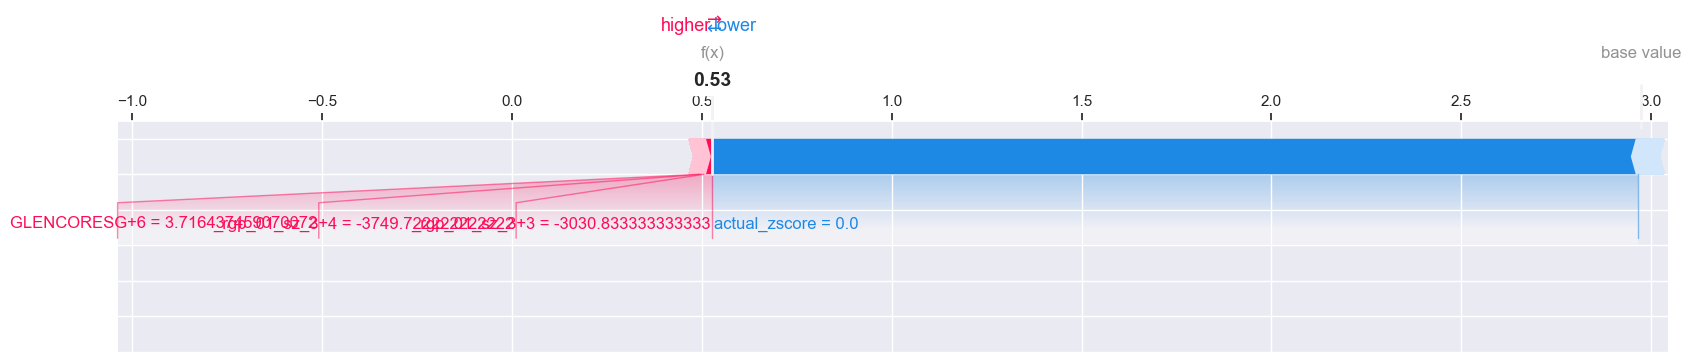

In [25]:
import matplotlib
shap.force_plot(explainer.expected_value, shap_values, features.iloc[0, :],  matplotlib=matplotlib)

In [32]:
len(features.iloc[0, :])

743

In [28]:
from IPython.core.display import display, HTML
shap.initjs()

explainer = shap.TreeExplainer(model)
plot = shap.force_plot(explainer.expected_value, shap_values[:], features.iloc[0, :], matplotlib=False)
shap_html = f"{shap.getjs()}{plot.html()}"
display(HTML(shap_html))

In [82]:
def _force_plot_html(*args):
    force_plot = shap.force_plot(*args, matplotlib=False)
    shap_html = f"<head>{shap.getjs()}</head><body>{force_plot.html()}</body>"
    return html.Iframe(srcDoc=shap_html,
                       style={"width": "100%", "height": "200px", 
                       "border": 0})
    
def shap_plot(ind): 
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features)
    p = shap.force_plot(explainer.expected_value, shap_values[ind], features.iloc[[ind]])
    plt.savefig('temp.svg')
    plt.close()
    return p
shap_plot(3)

In [86]:
shap_plot = shap.force_plot(explainer.expected_value, 
    shap_values, features=features.iloc[-1:], 
    feature_names=features.columns,
    matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'])

In [77]:
create_waterfall(features, model)